【問題1】SVM分類器のクラスを作成する

In [1]:
class ScratchSVMClassifier():
    """
    Parameters
    ----------
    max_iter : int
      イテレーション回数
    lr : float
      学習率
    kernel_type : str , default='linear' 
      カーネルの設定 
    
    Attributes
    ----------
    kernel : 次の形のndarray (n_samples, n_samples)
      kernelのi,j行列
    lagrangian: float
      ラグランジュ乗数 lambda
    support_vector_index : 次の形のndarray (n_samples, n_samples)
     """
    def __init__(self,max_iter, lr, kernel_type='linear'):
        # parameterを属性として保持
        self.max_iter = max_iter
        self.lr = lr
        self.kernel_type = kernel_type
        self.lam = 0
        self.sv_index = 0
        self.sv = 0
    
    def make_kernel(self, X, S=None):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        S : support_vector ndarray, (n, n_features)
        """
        if self.kernel_type == 'linear':
            if S is None: 
                kernel = np.dot(X, X.T)
            else:
                kernel = np.dot(X, S.T)
            return kernel
    
    
    def update_lambda(self, X, y):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解ラベル[-1 or 1]
          
        """
        #カーネル関数の呼び出し
        kernel = self.make_kernel(X)
        #更新式 λi=λi+α(1-Σλj yi yj k(xi,xj))
        self.lam = self.lam + self.lr * (1- np.dot(np.dot(y, y.T)*kernel, self.lam))
        
    def fit(self, X, y):
        """
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
            
        return
        support_vectorのindex
        """
        y = y[:,np.newaxis]
        # 閾値
        threshold = 1e-4
        # lambdaの初期値を設定する 次の形のndarray np.array(n_samples,1)
        self.lam = (np.random.rand(X.shape[0])*1e-5)[:,np.newaxis]

        # 更新する
        for _ in range(self.max_iter):
            self.update_lambda(X, y)
            self.lam = np.where(self.lam>0, self.lam, 0) # 負の値を0に
            
        self.sv_index = np.where(self.lam>threshold)[0] #thresholdを超えたindex
        self.sv_y = y[self.sv_index,0][:,np.newaxis] # predict用
        self.sv = X[self.sv_index,:]
        
    def predict(self, X_test):
        # support_vectorと入力データのカーネルを算出
        ks = self.make_kernel(X_test, self.sv)
        # Σλn yn k(x,sn)の計算
        y_pred = np.dot(ks, self.lam[self.sv_index]*self.sv_y)
        # 要素が負の場合-1にし、正の場合1にする
        y_pred = np.where(y_pred<0, -1, y_pred)
        y_pred = np.where(y_pred>0, 1, y_pred)
        y_pred = y_pred[:,0] # vectorに
        
        return y_pred
     
    def accuracy(self, y_pred, y_test):
        # 配列を比較してnp.sumする
        accuracy = np.sum(y_pred == y_test) / len(y_test)

        return accuracy
        
        

In [2]:
import numpy as np
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('../ml-scratch/utils/df_simple1.csv')
X = df.iloc[:,1:3].values
y = df.loc[:,'y'].values
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2)

【問題5】時間の計測

In [4]:
%%time
ssvmc = ScratchSVMClassifier(max_iter=1000, lr=1e-7)
ssvmc.fit(X_train, y_train)

Wall time: 3.59 s


In [5]:
y_pred = ssvmc.predict(X_test)

【問題3】指標値の算出

In [6]:
ssvmc.accuracy(y_pred ,y_test)

1.0

【問題4】決定領域の可視化

In [50]:
def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    plt.scatter(ssvmc.sv[:,0], ssvmc.sv[:,1],marker="o", c="green",edgecolor="black",s=80)
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

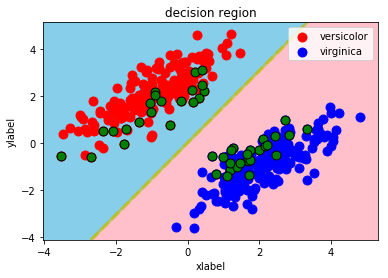

In [52]:
decision_region(X_train, y_train, model= ssvmc)

【問題6】ロジスティック回帰とSVM(分類)
ロジスティック回帰とSVMは本質的に何が異なっているか

ロジスティク回帰は1層のパーセプトロンをシグモイド関数を用いてクロスエントロピーで学習したものであり、
SVMは1層のパーセプトロンをカーネルを使用後ヒンジロス(距離が1より小さい場合にペナルティ)で学習したもの



ロジスティク回帰は尤度関数を最大化する確率であるのに対して
SVMは境界面からの距離を見ている



SVMはカーネルトリックによって比較的計算コストが安く(DNN等に比べて)非線形を獲得している
ロジスティク回帰は線形